# Finding the essential genes from background geneset

In [18]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats

from rich.table import Table
from rich.console import Console
from rich.panel import Panel

from utils.plot_utils import autosave

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150

def _resolve_project_root() -> Path:
    here = Path.cwd().resolve()
    for candidate in (here, *here.parents):
        if (candidate / 'config.py').exists():
            return candidate
    raise FileNotFoundError('config.py not found in cwd or parents')

PROJECT_ROOT = _resolve_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from config import (
    GENE_PATHS,
    VARIANT_PATHS,
    SOURCE_PALETTE,
    load_variant_pairs_matched,
)

print(f'project root: {PROJECT_ROOT}')
print('\navailable datasets:')
for name in ['clingen', 'clingen_null', 'background', 'background_null']:
    print(f'  {name}: {VARIANT_PATHS[name].name}')

project root: /Users/markus/in-silico-vg-analysis

available datasets:
  clingen: ClinGen_HI_Gnomad_variants_dedup_26012026.parquet
  clingen_null: ClinGen_HI_Synth_variants_downsampled_perm_26012026.parquet
  background: Background_Gnomad_variants_dedup_perm_26012026.parquet
  background_null: Background_Synth_variants_downsampled_perm_26012026.parquet


In [19]:
CLINGEN_VAR = VARIANT_PATHS['clingen']
BG_VAR = VARIANT_PATHS['background']
BG_NULL_VAR = VARIANT_PATHS['background_null']
CLINGEN_NULL_VAR = VARIANT_PATHS['clingen_null']

CLINGEN_GENE = GENE_PATHS['clingen']
BG_GENE = GENE_PATHS['background']
BG_NULL_GENE = GENE_PATHS['background_null']
CLINGEN_NULL_GENE = GENE_PATHS['clingen_null']

PATHS = {
    'background': BG_VAR,
    'background_null': BG_NULL_VAR,
    'clingen': CLINGEN_VAR,
    'clingen_null': CLINGEN_NULL_VAR,
}

df = pl.read_parquet(BG_VAR)
print(df.columns)

['variant_id', 'scored_interval', 'gene_id', 'gene_name', 'gene_type', 'gene_strand', 'junction_Start', 'junction_End', 'output_type', 'variant_scorer', 'track_name', 'track_strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'gtex_tissue', 'raw_score', 'quantile_score', 'scored_interval_str', 'is_anchor', 'seq_len', 'scorer_friendly', 'gene_norm', 'CHROM', 'POS', 'REF', 'ALT', 'gene_tag', 'method_friendly', 'variant_id_canonical', 'CHROM_af', 'POS_af', 'REF_af', 'ALT_af', 'AF', 'perm_AF']


## Load Data

load variant and gene-level data using convenience functions

### Variant level

In [ ]:
real_bg = pl.read_parquet(VARIANT_PATHS['background'])
null_bg = pl.read_parquet(VARIANT_PATHS['background_null'])
real_cg = pl.read_parquet(VARIANT_PATHS['clingen'])
null_cg = pl.read_parquet(VARIANT_PATHS['clingen_null'])

# We rename 'perm_AF' to 'AF' in null sets immediately to simplify downstream math
variant_tables = {
    'background': real_bg,
    'background_null': null_bg.rename({'perm_AF': 'AF'}) if 'perm_AF' in null_bg.columns else null_bg,
    'clingen': real_cg,
    'clingen_null': null_cg.rename({'perm_AF': 'AF'}) if 'perm_AF' in null_cg.columns else null_cg,
}

# 3. Load and Filter Gene Metadata
print("Loading and aligning gene metadata...")
gene_tables = {
    'background': pl.read_parquet(GENE_PATHS['background']),
    'background_null': pl.read_parquet(GENE_PATHS['background_null']),
    'clingen': pl.read_parquet(GENE_PATHS['clingen']),
    'clingen_null': pl.read_parquet(GENE_PATHS['clingen_null']),
}

# Filter gene tables to only include genes present in the variant sets
for name in gene_tables:
    # 1. Get unique gene IDs from the variant table
    valid_genes = variant_tables[name]['gene_id'].unique().to_list()

    # 2. Filter the gene table
    gene_tables[name] = gene_tables[name].filter(pl.col('gene_id').is_in(valid_genes))

    print(f"  {name}: aligned to {gene_tables[name].height} genes")

Loading variant tables...
Loading and aligning gene metadata...
  background: aligned to 349 genes
  background_null: aligned to 349 genes
  clingen: aligned to 316 genes
  clingen_null: aligned to 316 genes


### Gene level

## Gene-Level Vg (Observed vs Simulated)

[save_plot] Saved: interactive_Vg_Observed_vs_Simulated_Comparison_27012026_1408.pdf
[save_plot] Saved: interactive_Vg_Observed_vs_Simulated_Comparison_27012026_1408.svg


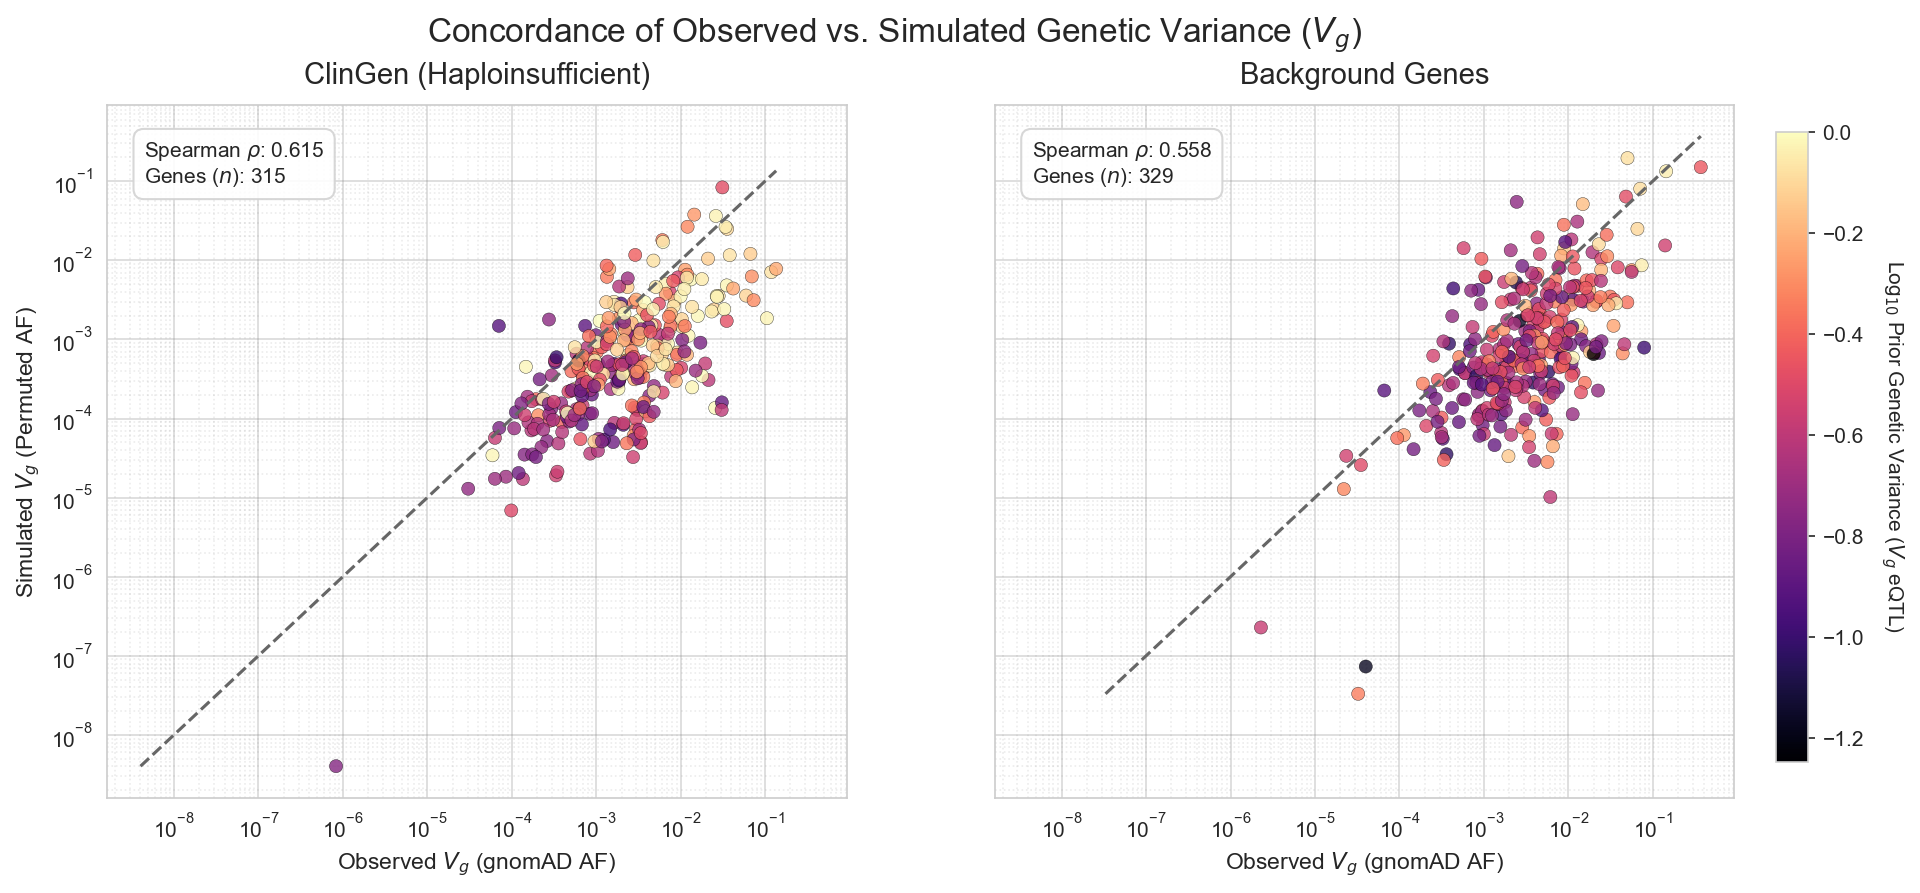

In [ ]:
def compute_gene_vg(variant_df: pl.DataFrame, af_col: str, out_col: str) -> pl.DataFrame:
    """Computes variant-level Vg contribution and sums it per gene."""
    # If pre-calculated column exists
    if "vg_predicted" in variant_df.columns and af_col == "AF":
        return variant_df.group_by("gene_id").agg(pl.col("vg_predicted").sum().alias(out_col))
    
    # Otherwise calculate 2pq * beta^2
    return (
        variant_df.with_columns(
            (2.0 * pl.col(af_col) * (1.0 - pl.col(af_col)) * pl.col("raw_score").pow(2))
            .alias("vg_contribution")
        )
        .group_by("gene_id")
        .agg(pl.col("vg_contribution").sum().alias(out_col))
    )

plot_data = {}
datasets = ['clingen', 'background']
all_log_priors = [] 

for name in datasets:
    # Compute Observed Vg
    real_df = variant_tables[name]
    vg_obs = compute_gene_vg(real_df, "AF", "vg_predicted")
    
    # Compute Simulated Vg (handle potential column name differences)
    null_df = variant_tables[f"{name}_null"]
    null_af_col = "AF" if "AF" in null_df.columns else "perm_AF"
    vg_sim = compute_gene_vg(null_df, null_af_col, "vg_predicted_perm")
    
    merged_vg = vg_obs.join(vg_sim, on="gene_id", how="inner")
    
    # Get Real Vg (Prior)
    gene_metadata = gene_tables[name].select(['gene_id', 'vg_eqtl'])
    
    # Final Join and Filter
    final_df = merged_vg.join(
        gene_metadata, on="gene_id", how="left"
    ).filter(
        (pl.col("vg_predicted") > 0) & 
        (pl.col("vg_predicted_perm") > 0) &
        (pl.col("vg_eqtl").is_not_null())
    ).to_pandas() # Convert to Pandas for Seaborn/Matplotlib
    
    # Log transform for color scale
    final_df["log_prior_vg"] = np.log10(final_df["vg_eqtl"] + 1e-9)
    
    plot_data[name] = final_df
    all_log_priors.append(final_df["log_prior_vg"])

# Global normalization for shared colorbar
global_vmin = np.min([s.min() for s in all_log_priors])
global_vmax = np.max([s.max() for s in all_log_priors])
norm = plt.Normalize(global_vmin, global_vmax)

with autosave("Vg_Observed_vs_Simulated_Comparison", verbose=True):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    titles = {
        'clingen': 'ClinGen (Haploinsufficient)',
        'background': 'Background Genes'
    }

    for ax, name in zip(axes, datasets):
        pdf = plot_data[name]
        
        # Stats
        corr, p_val = stats.spearmanr(pdf["vg_predicted"], pdf["vg_predicted_perm"])
        count = len(pdf)


        sns.scatterplot(
            data=pdf,
            x="vg_predicted",
            y="vg_predicted_perm",
            hue="log_prior_vg",
            hue_norm=norm,
            palette="magma",
            ax=ax,
            alpha=0.8,
            edgecolor='k',
            linewidth=0.2,
            s=40,
            legend=False 
        )
        
        # Identity Line
        all_vals = np.concatenate([pdf["vg_predicted"], pdf["vg_predicted_perm"]])
        min_val, max_val = all_vals.min(), all_vals.max()
        ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".4", lw=1.5, label="Identity")
        
        # Statistical Annotation
        stats_text = (
            f"Spearman $\\rho$: {corr:.3f}\n"
            f"Genes ($n$): {count:,}"
        )
        ax.text(0.05, 0.95, stats_text,
                transform=ax.transAxes, fontsize=10, va='top', ha='left',
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgray', boxstyle='round,pad=0.5'))
        
        # Axes Styling
        ax.set_title(titles[name], fontsize=14, pad=10)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"Observed $V_g$ (gnomAD AF)", fontsize=11)
        
        if ax == axes[0]:
            ax.set_ylabel(r"Simulated $V_g$ (Permuted AF)", fontsize=11)
        else:
            ax.set_ylabel("")
            
        ax.grid(True, which="major", ls="-", alpha=0.3, color="gray")
        ax.grid(True, which="minor", ls=":", alpha=0.15, color="gray")

    # Colorbar
    plt.subplots_adjust(right=0.9) # Space for cbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7]) 
    sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(r"Log$_{10}$ Prior Genetic Variance ($V_g$ eQTL)", rotation=270, labelpad=20)

    plt.suptitle(r"Concordance of Observed vs. Simulated Genetic Variance ($V_g$)", fontsize=16, y=0.98)

Here we compare the **Observed Genetic Variance ** (from real gnomAD data) against a **Simulated ** (from a permutated synthetic model).

* **Left Panel:** ClinGen Haploinsufficient genes (essential, dosage-sensitive).
* **Right Panel:** Background genes (general set).
* **Color:** Represents prior variance from eQTLs ( eQTL); darker colors mean lower prior variance.

Both groups show strong agreement between observed and simulated variance (Spearman  for ClinGen vs.  for Background). This suggests that a gene's "capacity" for variance is largely determined by its structure (number of variants/sites) rather than selection alone. The ClinGen genes (left) generally cluster the identity line or sit slightly *above* it. So their **Simulated** variance (random chance) is often higher than their **Observed** variance, confirming that natural selection is actively suppressing variation in these essential genes.

The **low-variance genes (dark purple dots)** in the ClinGen set are clustered more distinctly in the "low observed / higher simulated" region (top-left relative to the diagonal). This tells us that genes with naturally low regulatory variance are under tighter constraint, preventing them from accumulating the structural variance that a random model predicts.

[save_plot] Saved: interactive_Decoupling_Constraint_Candidates_27012026_1407.pdf
[save_plot] Saved: interactive_Decoupling_Constraint_Candidates_27012026_1407.svg
Constraint Threshold: -0.3 (Score < -0.3)
High VeQTL Threshold: 0.5 (VeQTL > 0.5)
------------------------------------------------------------
Total Background Genes:     329
Neutral (Gray Cloud):       304
Coupled Hits (Blue Dots):   22
Uncoupled Hits (Stars):     3
------------------------------------------------------------

TOP UNCOUPLED 'STAR' CANDIDATES (Constraint + Flexibility):
Gene ID              Score      VeQTL     
----------------------------------------
ENSG00000167034      -0.591      0.835
ENSG00000109738      -0.539      0.674
ENSG00000163126      -0.440      0.654


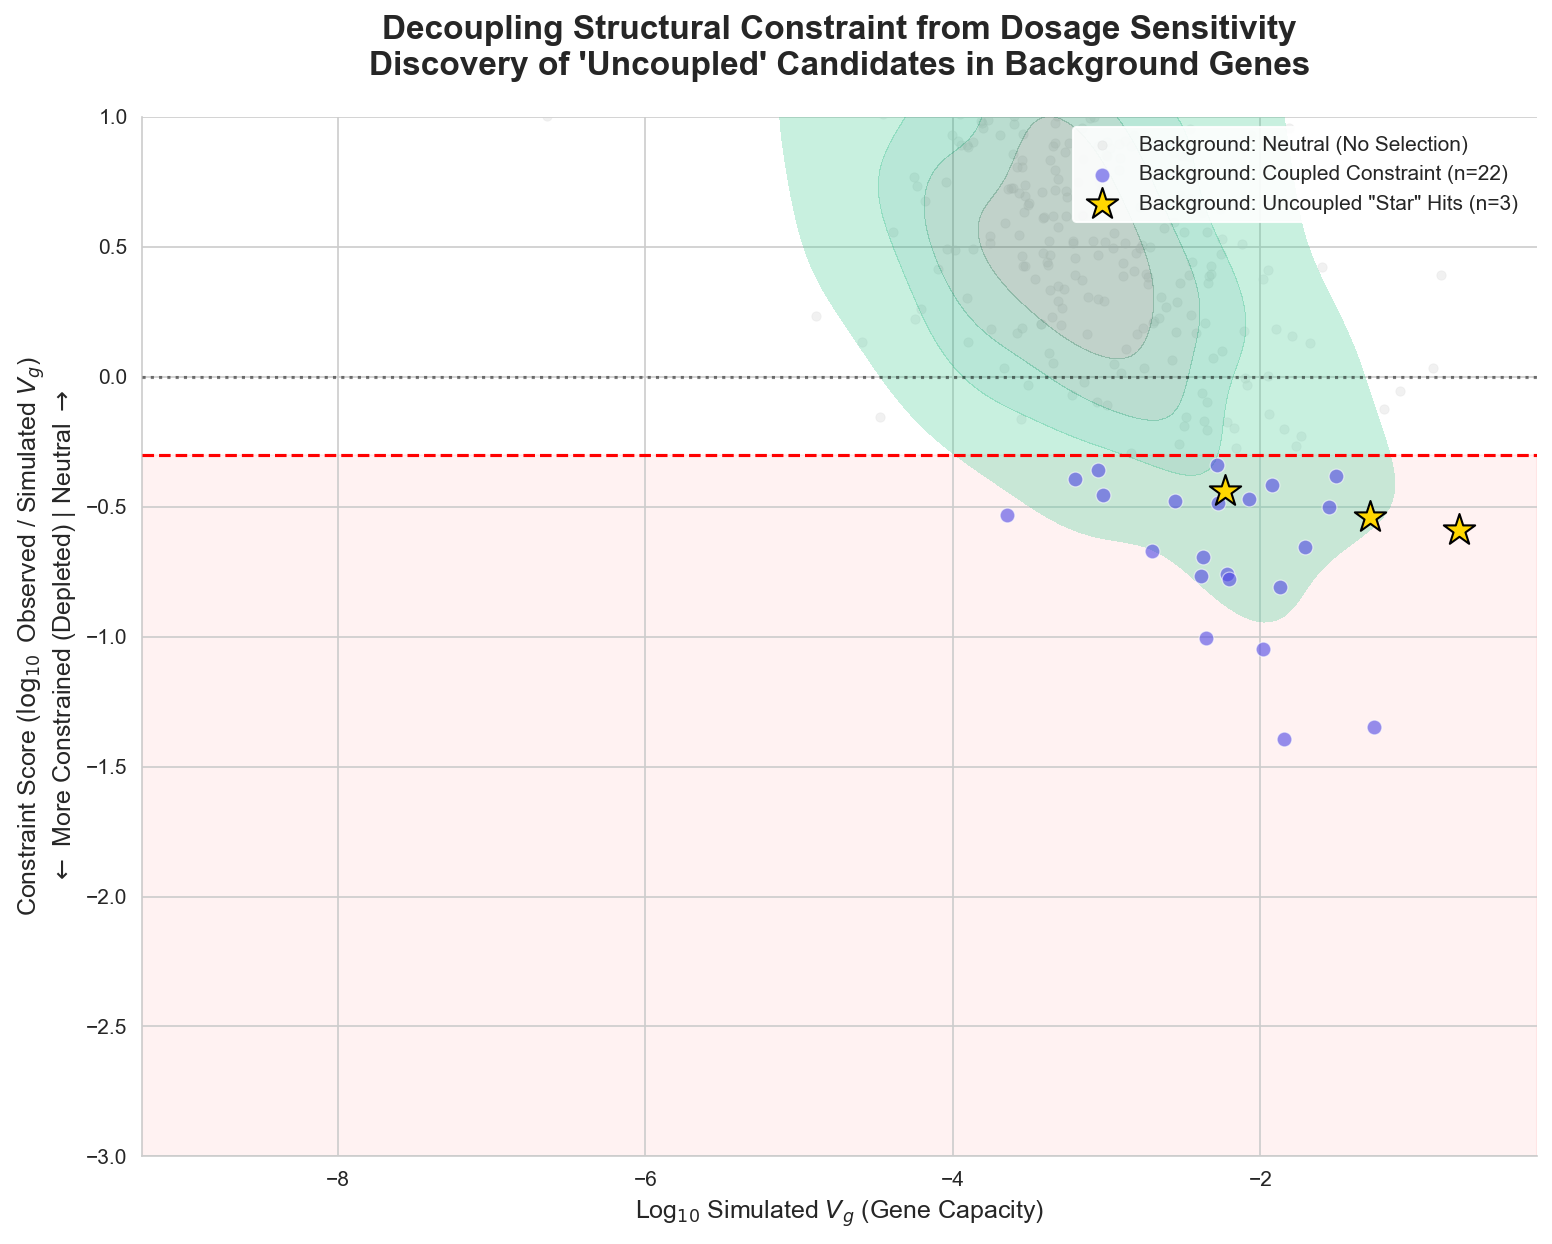

In [ ]:
THRESHOLDS = {
    'constraint_score': -0.30,  # The "Discovery Zone" ceiling
    'veqtl_high': 0.50,         # Minimum prior variance to be "Uncoupled"
    'robustness_check': -1.0    # Extreme threshold for stress testing
}

if 'plot_data' not in locals():
    raise ValueError("Please run the aggregation step first to generate 'plot_data'.")


bg_df = plot_data['background'].copy()
bg_df['log_sim'] = np.log10(bg_df['vg_predicted_perm'])
bg_df['constraint_score'] = np.log10(bg_df['vg_predicted'] / bg_df['vg_predicted_perm'])
bg_df['vg_eqtl'] = bg_df['vg_eqtl'].fillna(0.0)

# 1. In Discovery Zone? (Score < -0.3)
bg_df['in_zone'] = bg_df['constraint_score'] < THRESHOLDS['constraint_score']

# 2. Uncoupled? (In Zone + High VeQTL) -> "Star Hits"
bg_df['is_uncoupled'] = bg_df['in_zone'] & (bg_df['vg_eqtl'] > THRESHOLDS['veqtl_high'])

# 3. Coupled? (In Zone + Low VeQTL)
bg_df['is_coupled'] = bg_df['in_zone'] & (bg_df['vg_eqtl'] <= THRESHOLDS['veqtl_high'])

# Prepare Subsets
neutral_genes = bg_df[~bg_df['in_zone']]
coupled_hits = bg_df[bg_df['is_coupled']]
uncoupled_hits = bg_df[bg_df['is_uncoupled']]

# Prepare Contours (ClinGen)
cg_df = plot_data['clingen'].copy()
cg_df['log_sim'] = np.log10(cg_df['vg_predicted_perm'])
cg_df['constraint_score'] = np.log10(cg_df['vg_predicted'] / cg_df['vg_predicted_perm'])


# --- 2. Plotting with Autosave ---
# The filename will be generated automatically: [date]_Decoupling_Constraint_Candidates.pdf

with autosave("Decoupling_Constraint_Candidates", verbose=True):
    fig, ax = plt.subplots(figsize=(12, 9))

    # A. Neutral Cloud (Gray)
    sns.scatterplot(
        data=neutral_genes, x='log_sim', y='constraint_score',
        color='lightgray', alpha=0.3, s=20, ax=ax, edgecolor=None,
        label='Background: Neutral (No Selection)',
        zorder=1,
        rasterized=True 
    )

    # B. Essential Gene Contours (ClinGen) -> Keep as Vector
    sns.kdeplot(
        data=cg_df, x='log_sim', y='constraint_score',
        levels=5, color=SOURCE_PALETTE['clingen'], alpha=0.3, fill=True, ax=ax,
        label='ClinGen: Essential Gene Density',
        zorder=2
    )

    # C. Coupled Hits (Blue) -> Keep as Vector
    sns.scatterplot(
        data=coupled_hits, x='log_sim', y='constraint_score',
        color=SOURCE_PALETTE['background'], alpha=0.6, s=50, ax=ax, marker='o',
        label=f'Background: Coupled Constraint (n={len(coupled_hits)})',
        zorder=3
    )

    # D. Uncoupled STAR HITS (Gold) -> Keep as Vector (Highlight)
    sns.scatterplot(
        data=uncoupled_hits, x='log_sim', y='constraint_score',
        color='#FFD700', edgecolor='k', linewidth=1, s=250, ax=ax, marker='*',
        label=f'Background: Uncoupled "Star" Hits (n={len(uncoupled_hits)})', 
        zorder=10
    )

    ax.axhline(THRESHOLDS['constraint_score'], color='red', linestyle='--', linewidth=1.5, zorder=5)
    # The shaded region shows the "Discovery Zone"
    ax.axhspan(-4, THRESHOLDS['constraint_score'], color='red', alpha=0.05, zorder=0)
    ax.axhline(0, color='k', linestyle=':', alpha=0.5, zorder=5)

    ax.set_title(
        "Decoupling Structural Constraint from Dosage Sensitivity\nDiscovery of 'Uncoupled' Candidates in Background Genes",
        fontsize=16, pad=20, fontweight='bold'
    )
    ax.set_ylabel(r"Constraint Score ($\log_{10}$ Observed / Simulated $V_g$)" + "\n" + r"$\leftarrow$ More Constrained (Depleted) | Neutral $\rightarrow$", fontsize=12)
    ax.set_xlabel(r"Log$_{10}$ Simulated $V_g$ (Gene Capacity)", fontsize=12)
    ax.set_ylim(bottom=-3.0, top=1.0)
    
    # Legend placement
    ax.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='white')

    sns.despine()
    # No plt.show() needed; autosave handles it.

# --- 3. Console Reporting ---
print(f"Constraint Threshold: {THRESHOLDS['constraint_score']} (Score < -0.3)")
print(f"High VeQTL Threshold: {THRESHOLDS['veqtl_high']} (VeQTL > 0.5)")
print("-" * 60)

print(f"Total Background Genes:     {len(bg_df)}")
print(f"Neutral (Gray Cloud):       {len(neutral_genes)}")
print(f"Coupled Hits (Blue Dots):   {len(coupled_hits)}")
print(f"Uncoupled Hits (Stars):     {len(uncoupled_hits)}")
print("-" * 60)

if not uncoupled_hits.empty:
    print("\nTOP UNCOUPLED 'STAR' CANDIDATES (Constraint + Flexibility):")
    # Sort by how constrained they are
    cols = ['gene_id', 'constraint_score', 'vg_eqtl']
    top_stars = uncoupled_hits.sort_values('constraint_score').head(10)[cols]
    
    # Simple formatting
    print(f"{'Gene ID':<20} {'Score':<10} {'VeQTL':<10}")
    print("-" * 40)
    for _, row in top_stars.iterrows():
        print(f"{row['gene_id']:<20} {row['constraint_score']:.3f}      {row['vg_eqtl']:.3f}")

So this is a **discovery plot** designed to filter the Background gene set for rare candidates. It separates genes based on how much natural selection has "depleted" their variance (y-axis) versus their theoretical capacity for variance (x-axis).

We can see that (The "Neutral" Majority (Gray)) most background genes (304/329) float above the red dashed line. This confirms they are largely unconstrained and tolerate structural variation well.

The "Essential-Like" Cluster (Blue) shows that are 22 genes that dive deep into the pink "constrained zone" (score < -0.3). These behave exactly like the ClinGen essential genes (green contours)—they are rigid in both structure and regulation.

The "Uncoupled" (Gold Stars) - we have found **3 rare candidates** (e.g., *ENSG00000167034*) that are statistically different. They are under strong structural constraint (like essential genes) yet maintain high regulatory flexibility (high). This suggests they are "protein-rigid" but "expression-flexible"—a unique biological state distinct from typical haploinsufficiency.

In [10]:
# statistical tests also not to eyeball
bg_df = plot_data['background'].copy()
cg_df = plot_data['clingen'].copy()

# Calculate Constraint Scores: Log10(Observed / Simulated)
bg_scores = np.log10(bg_df['vg_predicted'] / bg_df['vg_predicted_perm']).dropna()
cg_scores = np.log10(cg_df['vg_predicted'] / cg_df['vg_predicted_perm']).dropna()

# Remove -inf if any (where Observed was 0) for stats calculation
bg_scores = bg_scores[np.isfinite(bg_scores)]
cg_scores = cg_scores[np.isfinite(cg_scores)]


# Let's test if  the Background set actually "Neutral" (Centered at 0)? one-sample T-test against population mean of 0.0
t_stat_bg, p_val_bg = stats.ttest_1samp(bg_scores, 0.0)

print(f"1. Background (Neutrality Check)")
print(f"   Median Score:  {np.median(bg_scores):.4f}")
print(f"   Mean Score:    {np.mean(bg_scores):.4f}")
print(f"   Std Dev:       {np.std(bg_scores):.4f}")
print(f"   (P-value): {p_val_bg:.2e}")


# Where do ClinGen (Essential) genes actually live?
t_stat_cg, p_val_cg = stats.ttest_ind(bg_scores, cg_scores, equal_var=False)

print(f"2. ClinGen (Essentiality Check)")
print(f"   Median Score:  {np.median(cg_scores):.4f}")
print(f"   Mean Score:    {np.mean(cg_scores):.4f}")
print(f"   Diff from Background: {t_stat_cg:.2f} sigma (p={p_val_cg:.2e})")

# Calculate the fold-change implied by the median
median_fold_change = 10**np.median(cg_scores)
print(f"   -> VERDICT: The 'Typical' Essential gene has {median_fold_change:.1%} of expected variance.")
print(f"      (Score of {np.median(cg_scores):.2f} implies Observed is ~{median_fold_change:.2f}x of Simulated)")

print("-" * 60)

# TEST C: What score represents the "Top 10% Most Constrained"? - finding out the deep zone
top_10_percentile = np.percentile(cg_scores, 10) # 10th percentile (lowest values)
print(f"3. DEEP ZONE (Top 10% Strictest Essentials)")
print(f"   Score Threshold: {top_10_percentile:.4f}")
print(f"   (This is where the darkest red contour on your plot should be)")

1. Background (Neutrality Check)
   Median Score:  0.6240
   Mean Score:    0.6255
   Std Dev:       0.6611
   (P-value): 1.87e-47
2. ClinGen (Essentiality Check)
   Median Score:  0.5631
   Mean Score:    0.6055
   Diff from Background: 0.40 sigma (p=6.86e-01)
   -> VERDICT: The 'Typical' Essential gene has 365.7% of expected variance.
      (Score of 0.56 implies Observed is ~3.66x of Simulated)
------------------------------------------------------------
3. DEEP ZONE (Top 10% Strictest Essentials)
   Score Threshold: -0.1068
   (This is where the darkest red contour on your plot should be)


Our "Synthetic Model" Consistently Underestimates Variance

- Both Background (`0.62`) and ClinGen (`0.56`) scores are strongly positive. So Real genes consistently have **~3-4x more genetic variance ()** than our randomized simulations predict. The baseline isn't 0 (neutral); it's shifted significantly to the right.
So the permutation strategy likely destroys the "clumpy" nature of real genetic data (linkage disequilibrium or variant clusters), making the simulated "random" gene look artificially smooth and low-variance. Post-hoc analysis needed for this. 

We cannot see a Global "Essentiality" Signal - The difference between Background and ClinGen is **statistically insignificant**. On average, a known essential gene looks exactly like a random background gene in this specific metric. They are effectively the same population distribution. so this suggests that total (dominated by common variants) is not a good proxy for "constraint." Essential genes tolerate common, benign variation just fine, which drowns out the signal of the missing rare, damaging variants.

"Constraint" - our "Deep Zone" (Top 10% strictest essentials) starts at a score of **-0.10**. So we have to go to the extreme tail (the bottom 10%) to find genes that actually have *less* variance than expected (Observed < Simulated). This explains why oyr "Discovery" plot had a huge gray cloud above the line and only a tiny cluster of blue/gold stars below it. Constraint is not the norm for this metric—it is the exception.

### 4. Single-Gene Discovery Profile

In [ ]:
def plot_variant_profile(gene_id: str, 
                         variant_df: pl.DataFrame, 
                         gene_name: str = None, 
                         constraint_val: float = None, 
                         veqtl_val: float = None):
    """
    Generates a detailed 4-panel variant profile for a specific gene.
    """
    gene_name = gene_name or gene_id
    
    # 1. Extract and Prep Data
    df_star = variant_df.filter(pl.col("gene_id") == gene_id).to_pandas().copy()
    
    if df_star.empty:
        print(f"No variants found for {gene_id}")
        return

    # A. Calculate Vg Contribution (2pq * Beta^2)
    # Note: Ensure 'AF' and 'raw_score' columns exist
    df_star['vg_contribution'] = 2.0 * df_star['AF'] * (1.0 - df_star['AF']) * (df_star['raw_score']**2)
    df_star = df_star.sort_values('vg_contribution', ascending=False).reset_index(drop=True)

    # B. Calculate Metrics
    total_variants = len(df_star)
    total_vg = df_star['vg_contribution'].sum()

    # C. Calculate N90 (Cumulative Variance)
    df_star['cum_frac'] = df_star['vg_contribution'].cumsum() / total_vg
    
    # Handle edge cases where cum_frac never hits 0.9 (unlikely but possible)
    if any(df_star['cum_frac'] >= 0.9):
        n90_threshold_idx = np.argmax(df_star['cum_frac'] >= 0.9)
        n90_count = n90_threshold_idx + 1
    else:
        n90_count = total_variants
        n90_threshold_idx = total_variants - 1

    # D. Labeling
    df_star['is_bottleneck'] = df_star.index <= n90_threshold_idx
    df_star['direction'] = np.where(df_star['raw_score'] > 0, 'Up', 'Down')

    # 2. Plotting with Autosave
    # Filename example: Candidate_ENSG000..._CDK5R1_Profile.pdf
    plot_title = f"Candidate_{gene_id}_{gene_name}_Profile"
    
    with autosave(plot_title, verbose=False):
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        # --- Panel 1: Variant Effects and Selection Gap ---
        ax = axes[0]
        sns.scatterplot(
            data=df_star, x='AF', y='raw_score', 
            hue='is_bottleneck', palette={True: '#e74c3c', False: '#3498db'}, 
            size='vg_contribution', sizes=(20, 400), 
            alpha=0.6, ax=ax, legend=False, edgecolor='none'
        )
        ax.set_xscale('log')
        ax.axhline(0, color='grey', lw=0.8)

        # Highlight "Forbidden Zone"
        ax.axvspan(1e-3, 1, ymin=0.7, ymax=1, color='red', alpha=0.05)
        ax.text(0.95, 0.95, "Forbidden Zone\n(Selection)", transform=ax.transAxes, 
                ha='right', va='top', fontsize=9, color='darkred', alpha=0.7)

        ax.set_title(f"Purifying Selection Profile\n(N={total_variants} variants)")
        ax.set_xlabel("Allele Frequency (log)")
        ax.set_ylabel("Structural Effect Size")

        # --- Panel 2: Cis-Variance Split (Up vs Down) ---
        up_v = df_star.loc[df_star['direction'] == 'Up', 'vg_contribution'].sum()
        dn_v = df_star.loc[df_star['direction'] == 'Down', 'vg_contribution'].sum()

        axes[1].pie(
            [up_v, dn_v], 
            labels=['Up-Reg', 'Down-Reg'], 
            colors=['#3498db', '#e67e22'],
            autopct=lambda p: f'{p:.1f}%\n({p/100*(up_v+dn_v):.1e})', 
            startangle=90,
            explode=(0.05, 0)
        )
        axes[1].set_title('Regulatory Direction Split')

        # --- Panel 3: Vg Distribution Histogram ---
        axes[2].hist(df_star['vg_contribution'], bins=30, log=True, color='grey', alpha=0.7, edgecolor='k')
        axes[2].set_title('Variance Contribution ($V_g$)')
        axes[2].set_xlabel('Variance per Variant')
        axes[2].set_ylabel('Count (log)')

        # --- Panel 4: Cumulative Concentration (N90) ---
        ax = axes[3]
        ax.plot(range(1, len(df_star)+1), df_star['cum_frac'], color='grey', lw=1.5)
        
        # Highlight N90
        if n90_count <= len(df_star):
            current_val = df_star['cum_frac'].iloc[n90_count-1]
            ax.scatter([n90_count], [current_val], color='#e74c3c', s=100, zorder=5)
            ax.axhline(0.9, ls=':', color='#e74c3c')
            ax.axvline(n90_count, ls=':', color='#e74c3c')

            ax.annotate(f'N90={n90_count}', 
                        xy=(n90_count, 0.9), 
                        xytext=(n90_count*2, 0.7),
                        arrowprops=dict(arrowstyle='->', color='black', connectionstyle="arc3,rad=.2"), 
                        fontweight='bold', color='#e74c3c')

        ax.set_xscale('log')
        ax.set_title('Structural Concentration (N90)')
        ax.set_xlabel('Variant Rank (log)')
        ax.set_ylabel('Cumulative Fraction of $V_g$')
        ax.set_ylim(0, 1.05)

        # Global Title
        header_text = f"Variant Profile: {gene_id}"
        if gene_name != gene_id: header_text += f" ({gene_name})"
        
        meta_text = f"| Variants: {total_variants}"
        if constraint_val: meta_text += f" | Constraint: {constraint_val:.2f}"
        if veqtl_val: meta_text += f" | $V_{{eQTL}}$: {veqtl_val:.2f}"
        
        plt.suptitle(header_text + " " + meta_text, fontsize=16, fontweight='bold', y=1.05)
        plt.tight_layout()
        
    print(f"Saved profile for {gene_id} ({gene_name})")


Found 3 'Uncoupled Star' candidates.
Generating detailed profiles for the TOP 5 most constrained candidates...
Saved profile for ENSG00000167034 (ENSG00000167034)
Saved profile for ENSG00000109738 (ENSG00000109738)
Saved profile for ENSG00000163126 (ENSG00000163126)


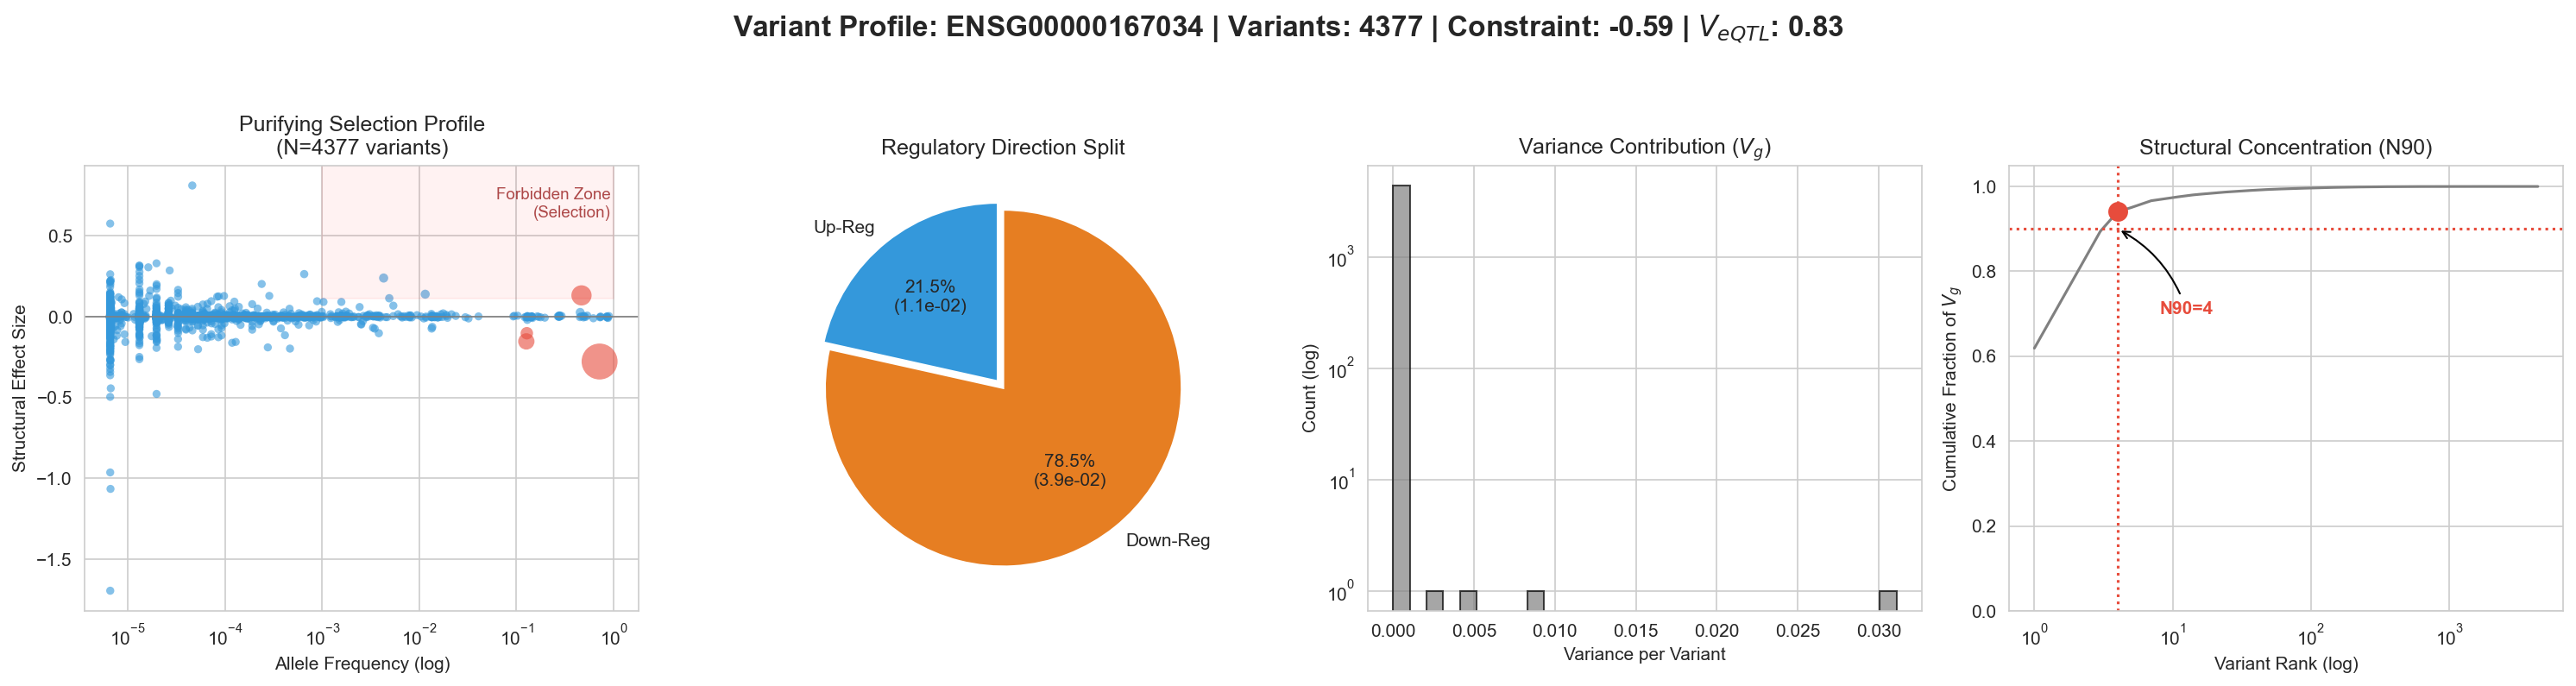

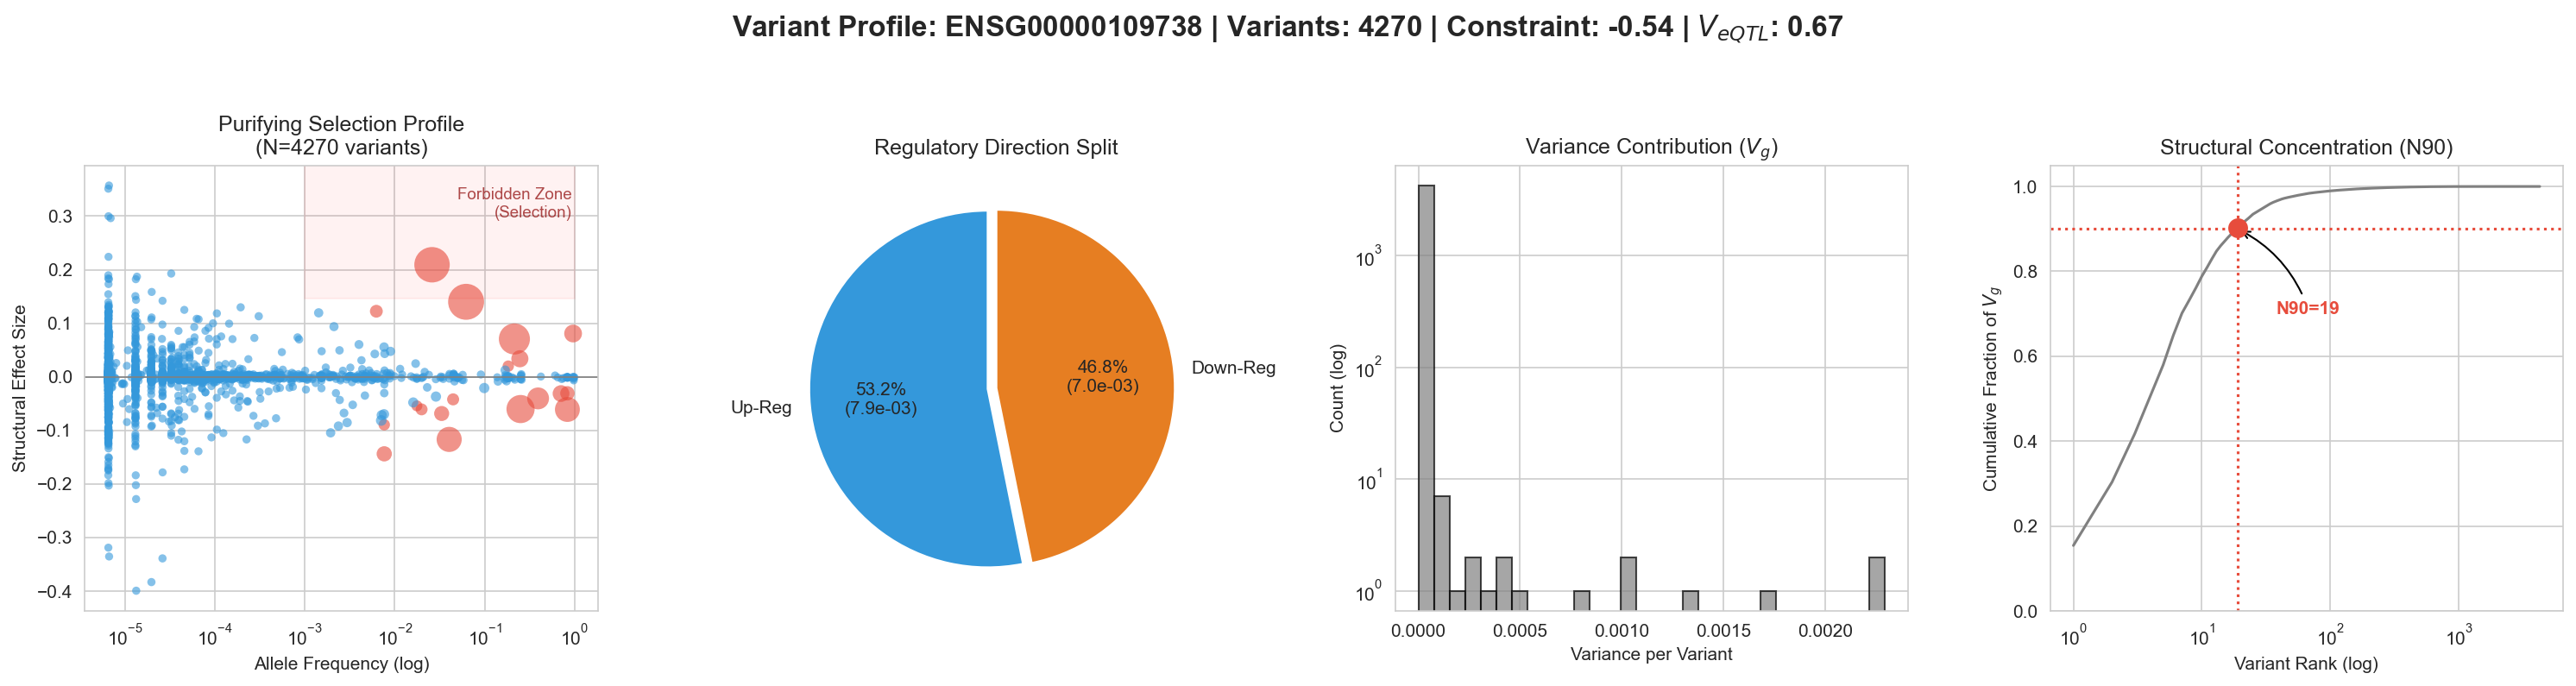

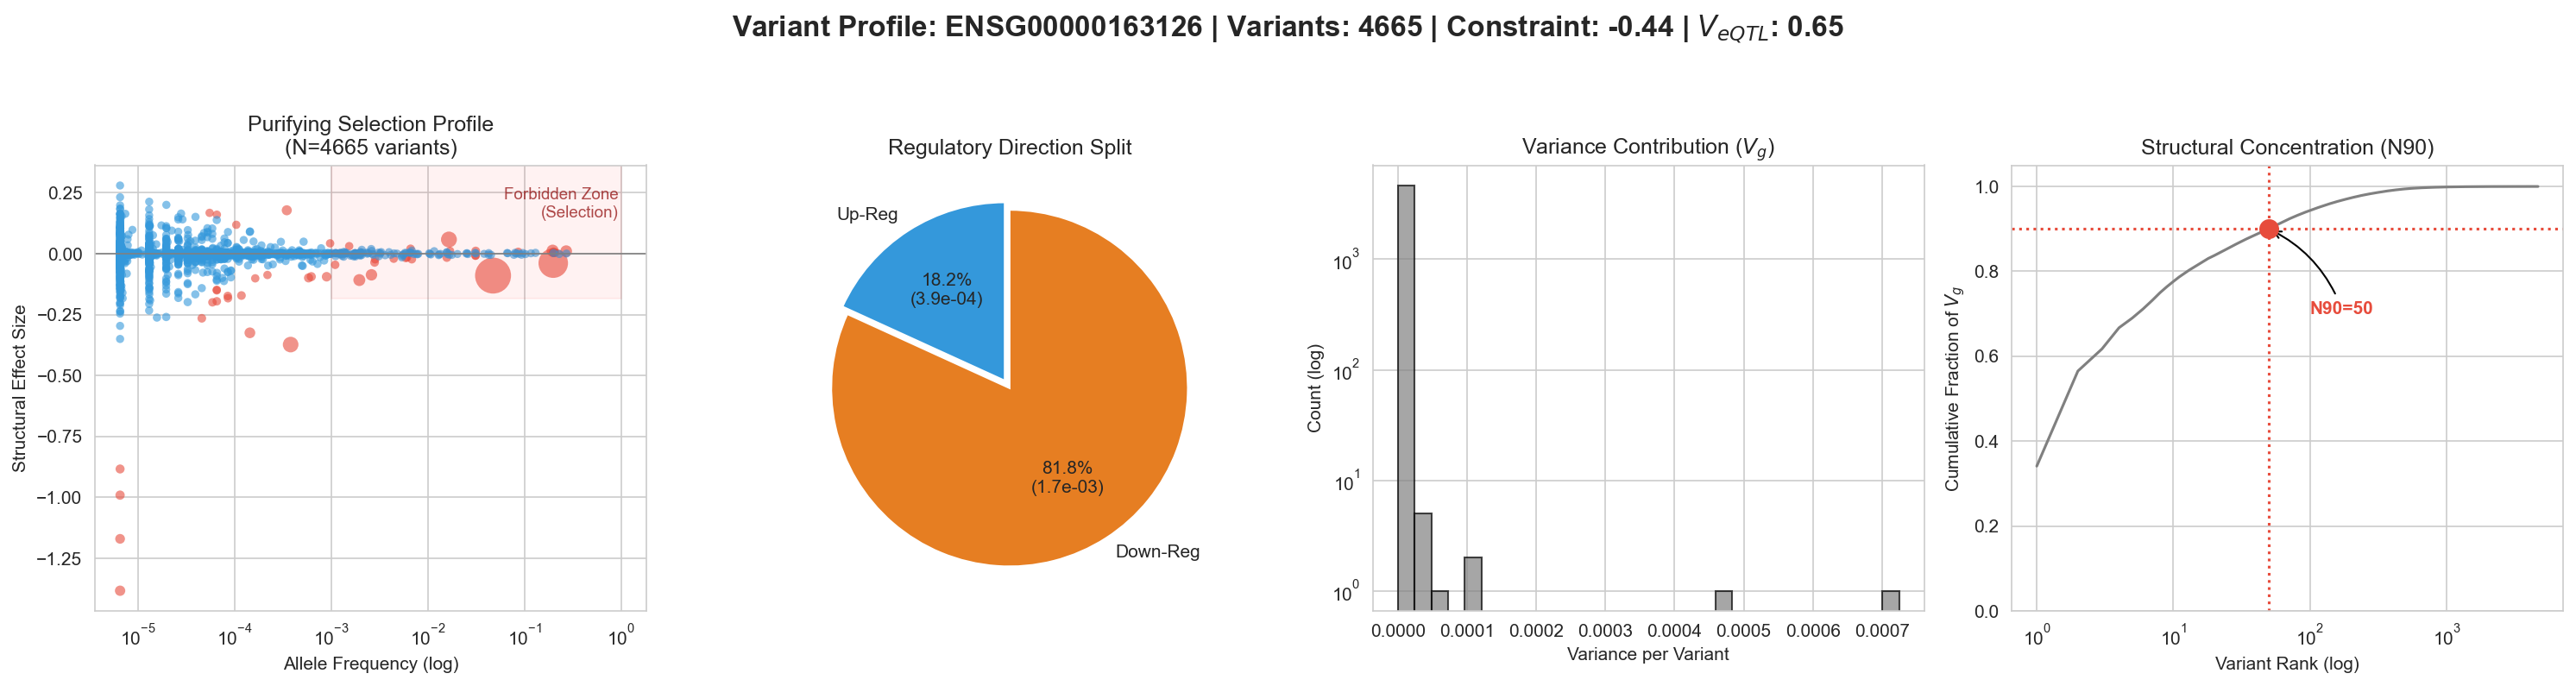

In [ ]:
bg_df = plot_data['background'].copy()
bg_df['log_sim'] = np.log10(bg_df['vg_predicted_perm'])
bg_df['constraint_score'] = np.log10(bg_df['vg_predicted'] / bg_df['vg_predicted_perm'])
bg_df['vg_eqtl'] = bg_df['vg_eqtl'].fillna(0.0)

# Classify Genes
bg_df['in_zone'] = bg_df['constraint_score'] < THRESHOLDS['constraint_score']
bg_df['is_uncoupled'] = bg_df['in_zone'] & (bg_df['vg_eqtl'] > THRESHOLDS['veqtl_high'])
bg_df['is_coupled'] = bg_df['in_zone'] & (bg_df['vg_eqtl'] <= THRESHOLDS['veqtl_high'])

# Prepare Subsets
neutral_genes = bg_df[~bg_df['in_zone']]
coupled_hits = bg_df[bg_df['is_coupled']]
uncoupled_hits = bg_df[bg_df['is_uncoupled']]
cg_df = plot_data['clingen'].copy()
cg_df['log_sim'] = np.log10(cg_df['vg_predicted_perm'])
cg_df['constraint_score'] = np.log10(cg_df['vg_predicted'] / cg_df['vg_predicted_perm'])


if not uncoupled_hits.empty:
    print(f"\nFound {len(uncoupled_hits)} 'Uncoupled Star' candidates.")
    print("Generating detailed profiles for the TOP 5 most constrained candidates...")
    
    # Sort by Constraint Score (most negative first)
    top_stars = uncoupled_hits.sort_values('constraint_score').head(5)
    
    for _, row in top_stars.iterrows():
        gid = row['gene_id']
        
        # Call the new function
        plot_variant_profile(
            gene_id=gid,
            # Pass the huge variant table (Polars)
            variant_df=variant_tables['background'], 
            gene_name=gid, # Or map to real name if you have a mapping
            constraint_val=row['constraint_score'],
            veqtl_val=row['vg_eqtl']
        )
else:
    print("No uncoupled candidates found to profile.")

Most insteresting finding is in the **Structural Concentration (N90)** panels for our top hoits: 

* **ENSG00000167034** is the good example: **N90 = 4**.
* Out of **4,377 variants**, only **4 variants** account for 90% of the gene's total genetic variance. So natural selection has "purged" almost all impactful variation from this gene, leaving only a tiny handful of tolerated variants to drive the bus. This explains *why* its constraint score is so high (-0.59)—the simulated model expects thousands of variants to contribute, but reality allows only 4.

### "Forbidden Zone" validation

**Purifying Selection Profile** (Panel 1 for each gene) proves the constraint:

* In all three stars, the **red "Forbidden Zone"** (High Frequency + High Effect Size) is nearly empty.
* **ENSG00000167034** is the cleanest example: The blue dots (variants) are squashed flat against the x-axis. Any variant that tries to have a high effect size (y-axis) is strictly kept at ultra-low frequency (left side), or purged entirely.

### 3. "Down-Regulation" bias

Looking at the **Regulatory Direction Split** (Pie Charts)

* **ENSG00000167034:** 78.5% Down-Regulation
* **ENSG00000163126:** 81.8% Down-Regulation
* So these "Uncoupled" genes are not just random; they specifically tolerate **loss** of expression (Down-Reg) much more than gain (Up-Reg). So this suggests these candidates are likely **dosage-sensitive** in a specific way: **Over-expression is toxic**. The cell can tolerate having *less* of the protein (hence high is allowed if it's down-regulating), but it cannot tolerate having too much (structural variants that might boost activity are purged).